# 환경설치

In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 필요한 라이브러리 설치 (코랩에서 실행)
!pip install torch torchvision matplotlib seaborn pandas numpy Pillow scikit-learn

# 기본 라이브러리 import
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import os

import matplotlib.font_manager as fm

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 시드 설정 (재현 가능한 결과를 위해)
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

 이미지 분석 파이프라인 초기화 (Device: cpu)
 이미지 파이프라인 완전 분석 시작
🔍 데이터 증강 효과 분석 시작...
    original 증강 분석 중...
    basic 증강 분석 중...
    medium 증강 분석 중...
    strong 증강 분석 중...
 샘플 이미지 비교 그래프 생성...
 픽셀 통계 분포 그래프 생성...


/tmp/ipython-input-2-2490239766.py:228: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(channel_data, labels=channel_labels)
/tmp/ipython-input-2-2490239766.py:287: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


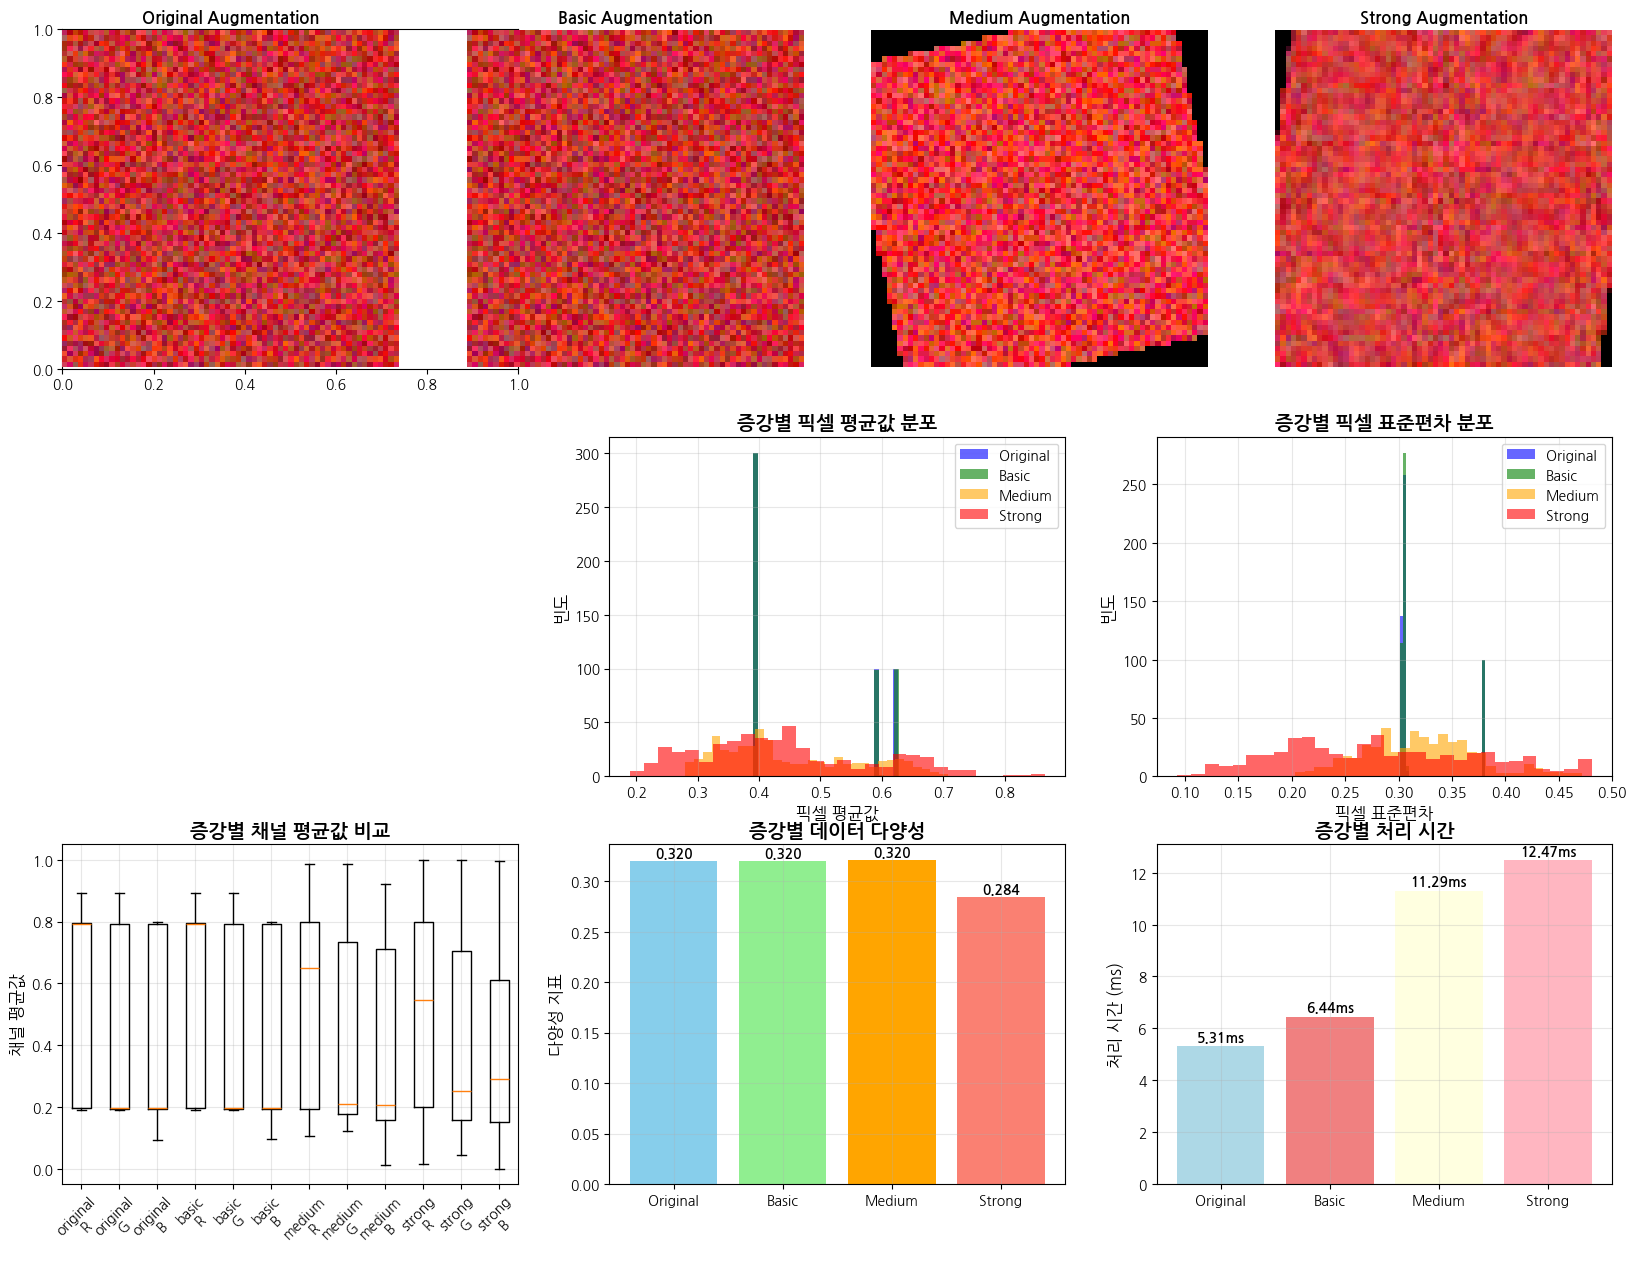


 증강 효과 분석 요약:
ORIGINAL | 픽셀평균: 0.480 | 다양성: 0.320 | 처리시간: 5.31ms
   BASIC | 픽셀평균: 0.480 | 다양성: 0.320 | 처리시간: 6.44ms
  MEDIUM | 픽셀평균: 0.449 | 다양성: 0.320 | 처리시간: 11.29ms
  STRONG | 픽셀평균: 0.440 | 다양성: 0.284 | 처리시간: 12.47ms

 이미지 파이프라인 분석 완료!


In [2]:
class ImageAnalysisPipeline:
    """이미지 데이터 파이프라인과 분석을 위한 클래스"""

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f" 이미지 분석 파이프라인 초기화 (Device: {self.device})")

    def create_fake_image_dataset(self, num_samples=1000, image_size=(3, 64, 64), num_classes=5):
        """가상 이미지 데이터셋 생성"""

        class FakeImageDataset(Dataset):
            def __init__(self, num_samples, image_size, num_classes, transform=None):
                self.num_samples = num_samples
                self.image_size = image_size
                self.num_classes = num_classes
                self.transform = transform

                # 클래스별로 다른 패턴의 이미지 생성
                self.images = []
                self.labels = []

                for i in range(num_samples):
                    class_id = i % num_classes

                    # 클래스별로 다른 특성을 가진 이미지 생성
                    if class_id == 0:  # 빨간색 계열
                        img = torch.zeros(image_size, dtype=torch.uint8)
                        img[0] = torch.randint(150, 255, image_size[1:])  # 빨간 채널
                        img[1] = torch.randint(0, 100, image_size[1:])    # 초록 채널
                        img[2] = torch.randint(0, 100, image_size[1:])    # 파란 채널
                    elif class_id == 1:  # 초록색 계열
                        img = torch.zeros(image_size, dtype=torch.uint8)
                        img[0] = torch.randint(0, 100, image_size[1:])
                        img[1] = torch.randint(150, 255, image_size[1:])
                        img[2] = torch.randint(0, 100, image_size[1:])
                    elif class_id == 2:  # 파란색 계열
                        img = torch.zeros(image_size, dtype=torch.uint8)
                        img[0] = torch.randint(0, 100, image_size[1:])
                        img[1] = torch.randint(0, 100, image_size[1:])
                        img[2] = torch.randint(150, 255, image_size[1:])
                    elif class_id == 3:  # 노란색 계열
                        img = torch.zeros(image_size, dtype=torch.uint8)
                        img[0] = torch.randint(200, 255, image_size[1:])
                        img[1] = torch.randint(200, 255, image_size[1:])
                        img[2] = torch.randint(0, 50, image_size[1:])
                    else:  # 보라색 계열
                        img = torch.zeros(image_size, dtype=torch.uint8)
                        img[0] = torch.randint(150, 255, image_size[1:])
                        img[1] = torch.randint(0, 100, image_size[1:])
                        img[2] = torch.randint(150, 255, image_size[1:])

                    self.images.append(img)
                    self.labels.append(class_id)

                self.class_names = ['빨강', '초록', '파랑', '노랑', '보라']

            def __len__(self):
                return self.num_samples

            def __getitem__(self, idx):
                image = self.images[idx]
                label = self.labels[idx]

                if self.transform:
                    # PIL 이미지로 변환 후 transform 적용
                    pil_image = transforms.ToPILImage()(image)
                    image = self.transform(pil_image)
                else:
                    image = transforms.ToTensor()(transforms.ToPILImage()(image))

                return image, label

        return FakeImageDataset

    def create_transforms(self):
        """다양한 레벨의 Transform 생성"""

        transforms_dict = {
            'original': transforms.Compose([
                transforms.ToTensor()
            ]),

            'basic': transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.ToTensor()
            ]),

            'medium': transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor()
            ]),

            'strong': transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.7),
                transforms.RandomRotation(degrees=30),
                transforms.RandomResizedCrop(64, scale=(0.7, 1.0)),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.ToTensor()
            ])
        }

        return transforms_dict

    def analyze_augmentation_effects(self):
        """데이터 증강 효과 분석"""

        print("🔍 데이터 증강 효과 분석 시작...")

        # 데이터셋 클래스와 transforms 생성
        fake_dataset_class = self.create_fake_image_dataset()
        transforms_dict = self.create_transforms()

        # 분석 결과 저장
        analysis_results = {}

        for aug_name, transform in transforms_dict.items():
            print(f"    {aug_name} 증강 분석 중...")

            # 각 증강 레벨별 데이터셋 생성
            dataset = fake_dataset_class(num_samples=500,
                                       image_size=(3, 64, 64),
                                       num_classes=5,
                                       transform=transform)

            dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

            # 통계 수집
            pixel_means = []
            pixel_stds = []
            channel_means = {'R': [], 'G': [], 'B': []}

            for batch_images, batch_labels in dataloader:
                # 전체 픽셀 통계
                pixel_means.extend(batch_images.mean(dim=[1,2,3]).tolist())
                pixel_stds.extend(batch_images.std(dim=[1,2,3]).tolist())

                # 채널별 통계
                channel_means['R'].extend(batch_images[:, 0].mean(dim=[1,2]).tolist())
                channel_means['G'].extend(batch_images[:, 1].mean(dim=[1,2]).tolist())
                channel_means['B'].extend(batch_images[:, 2].mean(dim=[1,2]).tolist())

            analysis_results[aug_name] = {
                'pixel_means': pixel_means,
                'pixel_stds': pixel_stds,
                'channel_means': channel_means,
                'dataset': dataset
            }

        return analysis_results

    def plot_augmentation_analysis(self, analysis_results):
        """증강 효과 분석 결과 시각화"""

        # 전체 figure 설정
        fig = plt.figure(figsize=(20, 15))

        # 1. 샘플 이미지 비교
        print(" 샘플 이미지 비교 그래프 생성...")

        ax1 = plt.subplot(3, 3, 1)
        transforms_dict = self.create_transforms()
        # Create an instance of the dataset class to get a sample image
        sample_dataset_instance = self.create_fake_image_dataset()(num_samples=1,
                                                        image_size=(3, 64, 64),
                                                        num_classes=5)

        original_image, _ = sample_dataset_instance[0]
        sample_images = []

        for aug_name, transform in transforms_dict.items():
            if aug_name == 'original':
                img = transforms.ToTensor()(transforms.ToPILImage()(original_image))
            else:
                pil_img = transforms.ToPILImage()(original_image)
                img = transform(pil_img)
            sample_images.append((aug_name, img))

        # 샘플 이미지들 표시
        for i, (name, img) in enumerate(sample_images):
            ax = plt.subplot(3, 4, i+1)
            img_show = img.permute(1, 2, 0).clamp(0, 1)
            ax.imshow(img_show)
            ax.set_title(f'{name.capitalize()} Augmentation', fontsize=12, fontweight='bold')
            ax.axis('off')

        # 2. 픽셀 평균값 분포 비교
        print(" 픽셀 통계 분포 그래프 생성...")

        ax2 = plt.subplot(3, 3, 5)
        colors = ['blue', 'green', 'orange', 'red']

        for i, (aug_name, results) in enumerate(analysis_results.items()):
            ax2.hist(results['pixel_means'], bins=30, alpha=0.6,
                    label=f'{aug_name.capitalize()}', color=colors[i])

        ax2.set_xlabel('픽셀 평균값', fontsize=12)
        ax2.set_ylabel('빈도', fontsize=12)
        ax2.set_title('증강별 픽셀 평균값 분포', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. 픽셀 표준편차 분포 비교
        ax3 = plt.subplot(3, 3, 6)

        for i, (aug_name, results) in enumerate(analysis_results.items()):
            ax3.hist(results['pixel_stds'], bins=30, alpha=0.6,
                    label=f'{aug_name.capitalize()}', color=colors[i])

        ax3.set_xlabel('픽셀 표준편차', fontsize=12)
        ax3.set_ylabel('빈도', fontsize=12)
        ax3.set_title('증강별 픽셀 표준편차 분포', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. 채널별 평균값 비교 (박스플롯)
        ax4 = plt.subplot(3, 3, 7)

        channel_data = []
        channel_labels = []

        for aug_name, results in analysis_results.items():
            for channel, values in results['channel_means'].items():
                channel_data.append(values)
                channel_labels.append(f'{aug_name}\n{channel}')

        ax4.boxplot(channel_data, labels=channel_labels)
        ax4.set_ylabel('채널 평균값', fontsize=12)
        ax4.set_title('증강별 채널 평균값 비교', fontsize=14, fontweight='bold')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)

        # 5. 증강 강도별 다양성 지표
        ax5 = plt.subplot(3, 3, 8)

        diversity_scores = []
        aug_names = []

        for aug_name, results in analysis_results.items():
            # 다양성을 표준편차의 평균으로 측정
            diversity = np.mean(results['pixel_stds'])
            diversity_scores.append(diversity)
            aug_names.append(aug_name.capitalize())

        bars = ax5.bar(aug_names, diversity_scores, color=['skyblue', 'lightgreen', 'orange', 'salmon'])
        ax5.set_ylabel('다양성 지표', fontsize=12)
        ax5.set_title('증강별 데이터 다양성', fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3)

        # 막대 위에 값 표시
        for bar, score in zip(bars, diversity_scores):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

        # 6. 증강별 처리 시간 비교
        ax6 = plt.subplot(3, 3, 9)

        # 처리 시간 측정
        processing_times = []
        transforms_dict = self.create_transforms()

        for aug_name, transform in transforms_dict.items():
            times = []
            for _ in range(10):  # 10번 측정 후 평균
                start_time = time.time()

                # 샘플 이미지 처리
                sample_img = torch.randint(0, 256, (3, 64, 64), dtype=torch.uint8)
                pil_img = transforms.ToPILImage()(sample_img)
                _ = transform(pil_img)

                times.append((time.time() - start_time) * 1000)  # ms 단위

            processing_times.append(np.mean(times))

        bars = ax6.bar(aug_names, processing_times, color=['lightblue', 'lightcoral', 'lightyellow', 'lightpink'])
        ax6.set_ylabel('처리 시간 (ms)', fontsize=12)
        ax6.set_title('증강별 처리 시간', fontsize=14, fontweight='bold')
        ax6.grid(True, alpha=0.3)

        # 막대 위에 값 표시
        for bar, time_val in zip(bars, processing_times):
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{time_val:.2f}ms', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # 요약 통계 출력
        print("\n 증강 효과 분석 요약:")
        print("=" * 60)

        for i, (aug_name, results) in enumerate(analysis_results.items()):
            mean_pixel = np.mean(results['pixel_means'])
            std_pixel = np.mean(results['pixel_stds'])
            process_time = processing_times[i]

            print(f"{aug_name.upper():>8} | 픽셀평균: {mean_pixel:.3f} | 다양성: {std_pixel:.3f} | 처리시간: {process_time:.2f}ms")

    def run_complete_analysis(self):
        """전체 분석 실행"""

        print(" 이미지 파이프라인 완전 분석 시작")
        print("=" * 60)

        # 1. 증강 효과 분석
        analysis_results = self.analyze_augmentation_effects()

        # 2. 결과 시각화
        self.plot_augmentation_analysis(analysis_results)

        print("\n 이미지 파이프라인 분석 완료!")

        return analysis_results

# 실행
image_pipeline = ImageAnalysisPipeline()
image_results = image_pipeline.run_complete_analysis()